In [225]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Dense ,Dropout, Bidirectional, Input, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
import os

In [329]:
def create_model(n_forecast, 
                 units, 
                 n_timesteps,
                 n_features=1,
                 optimizer=Adam(learning_rate=0.0001),
                 loss=MeanSquaredError(),
                 metrics=RootMeanSquaredError()):
    
    regressor = Sequential()
    
    regressor.add(InputLayer((n_timesteps, n_features)))
    
    regressor.add(LSTM(units=units))
    
    regressor.add(Dense(units=8, activation='relu'))
    
    regressor.add(Dense(units=n_forecast, activation='linear'))

    regressor.summary()

    regressor.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

    return regressor
    

def create_train_test_data(dataset, percent_train_data):
    size = len(dataset)
    target_idx = int((size / 100) * percent_train_data)

    train = dataset[:target_idx]
    test = dataset[target_idx:]

    return train, test, target_idx


def create_data(data, n_timesteps, n_forecast, n_features):
    x_data = []
    y_data = []

    for i in range(len(data)-n_timesteps-n_forecast+1):
        x_data.append(data[i:i+n_timesteps])
        y_data.append(data[i+n_timesteps:i+n_timesteps+n_forecast])

    x_data, y_data = np.array(x_data), np.array(y_data)
    x_data = np.reshape(x_data, (x_data.shape[0], x_data.shape[1], n_features))

    return x_data, y_data

In [331]:
n_timesteps = 15
n_features = 1
n_forecast = 10

In [97]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [355]:
df = pd.read_csv(csv_path)
df.head()

Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0       1307.75      1.03           1.75     152.3  
1       1309.80      0.72           1.50     136.1  
2       1310.24      0.19           0.63     171.6  
3       1309.19      0.34           0.50     198.0  
4       1309.00      0.32           0.63     214.3

In [357]:
df = df[5::6]
df.head()

Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
5   01.01.2009 01:00:00    996.50     -8.05    265.38        -8.78    94.4   
11  01.01.2009 02:00:00    996.62     -8.88    264.54        -9.77    93.2   
17  01.01.2009 03:00:00    996.84     -8.81    264.59        -9.66    93.5   
23  01.01.2009 04:00:00    996.99     -9.05    264.34       -10.02    92.6   
29  01.01.2009 05:00:00    997.46     -9.63    263.72       -10.65    92.2   

    VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
5           3.33          3.14          0.19       1.96             3.15   
11          3.12          2.90          0.21       1.81             2.91   
17          3.13          2.93          0.20       1.83             2.94   
23          3.07          2.85          0.23       1.78             2.85   
29          2.94          2.71          0.23       1.69             2.71   

    rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
5        1307.86      0.21           0.63     192.7  
11       1312.25      0.25           0.63     190.3  
17       1312.18      0.18           0.63     167.2  
23       1313.61      0.10           0.38     240.0  
29       1317.19      0.40           0.88     157.0

In [359]:
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')

In [361]:
df

Date Time  p (mbar)  T (degC)  Tpot (K)  \
Date Time                                                                
2009-01-01 01:00:00  01.01.2009 01:00:00    996.50     -8.05    265.38   
2009-01-01 02:00:00  01.01.2009 02:00:00    996.62     -8.88    264.54   
2009-01-01 03:00:00  01.01.2009 03:00:00    996.84     -8.81    264.59   
2009-01-01 04:00:00  01.01.2009 04:00:00    996.99     -9.05    264.34   
2009-01-01 05:00:00  01.01.2009 05:00:00    997.46     -9.63    263.72   
...                                  ...       ...       ...       ...   
2016-12-31 19:10:00  31.12.2016 19:10:00   1002.18     -0.98    272.01   
2016-12-31 20:10:00  31.12.2016 20:10:00   1001.40     -1.40    271.66   
2016-12-31 21:10:00  31.12.2016 21:10:00   1001.19     -2.75    270.32   
2016-12-31 22:10:00  31.12.2016 22:10:00   1000.65     -2.89    270.22   
2016-12-31 23:10:00  31.12.2016 23:10:00   1000.11     -3.93    269.23   

                     Tdew (degC)  rh (%)  VPmax (mbar)  VPact (mbar)  \
Date Time                                                              
2009-01-01 01:00:00        -8.78   94.40          3.33          3.14   
2009-01-01 02:00:00        -9.77   93.20          3.12          2.90   
2009-01-01 03:00:00        -9.66   93.50          3.13          2.93   
2009-01-01 04:00:00       -10.02   92.60          3.07          2.85   
2009-01-01 05:00:00       -10.65   92.20          2.94          2.71   
...                          ...     ...           ...           ...   
2016-12-31 19:10:00        -5.36   72.00          5.69          4.09   
2016-12-31 20:10:00        -6.84   66.29          5.51          3.65   
2016-12-31 21:10:00        -6.90   72.90          4.99          3.64   
2016-12-31 22:10:00        -7.15   72.30          4.93          3.57   
2016-12-31 23:10:00        -8.09   72.60          4.56          3.31   

                     VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  rho (g/m**3)  \
Date Time                                                                     
2009-01-01 01:00:00          0.19       1.96             3.15       1307.86   
2009-01-01 02:00:00          0.21       1.81             2.91       1312.25   
2009-01-01 03:00:00          0.20       1.83             2.94       1312.18   
2009-01-01 04:00:00          0.23       1.78             2.85       1313.61   
2009-01-01 05:00:00          0.23       1.69             2.71       1317.19   
...                           ...        ...              ...           ...   
2016-12-31 19:10:00          1.59       2.54             4.08       1280.70   
2016-12-31 20:10:00          1.86       2.27             3.65       1281.87   
2016-12-31 21:10:00          1.35       2.26             3.63       1288.02   
2016-12-31 22:10:00          1.37       2.22             3.57       1288.03   
2016-12-31 23:10:00          1.25       2.06             3.31       1292.41   

                     wv (m/s)  max. wv (m/s)  wd (deg)  
Date Time                                               
2009-01-01 01:00:00      0.21           0.63     192.7  
2009-01-01 02:00:00      0.25           0.63     190.3  
2009-01-01 03:00:00      0.18           0.63     167.2  
2009-01-01 04:00:00      0.10           0.38     240.0  
2009-01-01 05:00:00      0.40           0.88     157.0  
...                       ...            ...       ...  
2016-12-31 19:10:00      0.87           1.36     190.6  
2016-12-31 20:10:00      1.02           1.92     225.4  
2016-12-31 21:10:00      0.71           1.56     158.7  
2016-12-31 22:10:00      0.35           0.68     216.7  
2016-12-31 23:10:00      0.56           1.00     202.6  

[70091 rows x 15 columns]

In [117]:
temp = df.iloc[:,2].values
temp

array([-8.05, -8.88, -8.81, ..., -2.75, -2.89, -3.93])

In [333]:
df = pd.read_csv('dataset_days.csv', sep=',', index_col="time")
df.head()

Среднняя t  Минимальная t  Максимальная t  Суточная сумма осадков  \
time                                                                            
2019-05-24        13.6            8.9            17.5                     0.0   
2019-05-25        15.6           11.8            18.9                     0.3   
2019-05-26        18.1           14.3            23.6                     0.0   
2019-05-27        16.7           12.5            21.2                     0.0   
2019-05-28        22.0           15.9            28.4                     0.0   

            Глубина снега  Скорость ветра  Среднее давление hPa  \
time                                                              
2019-05-24            0.0             4.7                1012.7   
2019-05-25            0.0             4.6                1010.2   
2019-05-26            0.0             2.4                1004.7   
2019-05-27            0.0             4.7                1008.5   
2019-05-28            0.0             2.9                1014.1   

            Относительная влажность в %  
time                                     
2019-05-24                       64.125  
2019-05-25                       56.625  
2019-05-26                       62.375  
2019-05-27                       52.500  
2019-05-28                       48.250

In [335]:
temp = df.iloc[:,0].values
temp

array([13.6, 15.6, 18.1, ..., 21.6, 22.6, 22.6])

In [341]:
train, test, size = create_train_test_data(temp, 70)

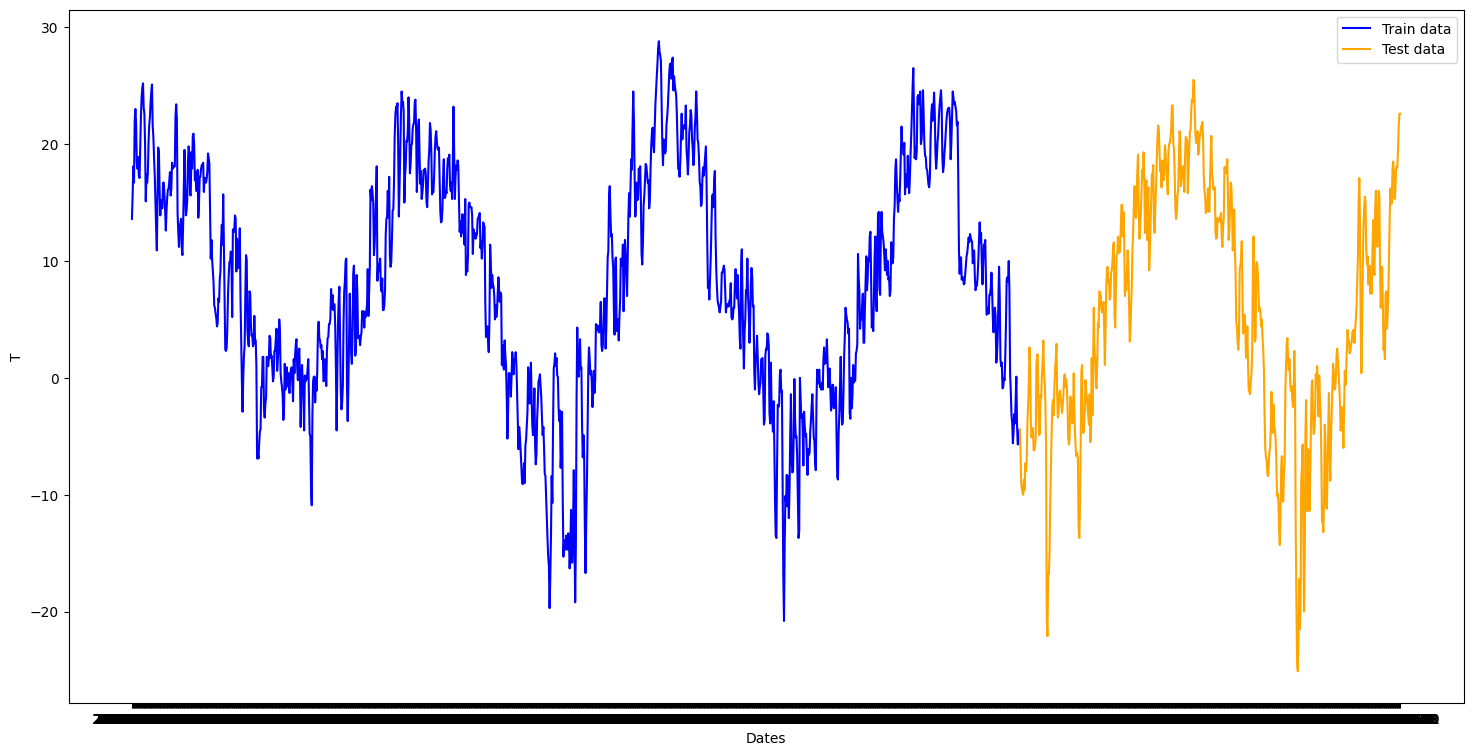

In [343]:
plt.figure(figsize=(18,9), dpi=100)
plt.xlabel('Dates')
plt.ylabel('T')
plt.plot(np.array(df.index[:size]), train, 'blue', label='Train data')
plt.plot(np.array(df.index[size:]), test, 'orange', label='Test data')
plt.legend()

In [345]:
x_train, y_train = create_data(train, n_timesteps, n_forecast, n_features)
x_test, y_test = create_data(test, n_timesteps, n_forecast, n_features)

In [347]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1260, 15, 1), (1260, 10), (527, 15, 1), (527, 10))

In [349]:
model = create_model(n_forecast=n_forecast,
                    units=64,
                    n_features = n_features,
                    n_timesteps=n_timesteps)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 64)                16896     
                                                                 
 dense_31 (Dense)            (None, 8)                 520       
                                                                 
 dense_32 (Dense)            (None, 10)                90        
                                                                 
Total params: 17,506
Trainable params: 17,506
Non-trainable params: 0
_________________________________________________________________


In [353]:
history = model.fit(x_train, y_train, epochs=10)

Epoch 1/100
40/40 [==============================] - 0s 5ms/step - loss: 112.6537 - root_mean_squared_error: 10.6138
Epoch 2/100
40/40 [==============================] - 0s 5ms/step - loss: 107.2262 - root_mean_squared_error: 10.3550
Epoch 3/100
40/40 [==============================] - 0s 5ms/step - loss: 102.2670 - root_mean_squared_error: 10.1127
Epoch 4/100
40/40 [==============================] - 0s 5ms/step - loss: 97.6997 - root_mean_squared_error: 9.8843
Epoch 5/100
40/40 [==============================] - 0s 5ms/step - loss: 93.2837 - root_mean_squared_error: 9.6583
Epoch 6/100
40/40 [==============================] - 0s 5ms/step - loss: 89.1452 - root_mean_squared_error: 9.4417
Epoch 7/100
40/40 [==============================] - 0s 5ms/step - loss: 85.1823 - root_mean_squared_error: 9.2294
Epoch 8/100
40/40 [==============================] - 0s 5ms/step - loss: 81.2752 - root_mean_squared_error: 9.0153
Epoch 9/100
40/40 [==============================] - 0s 5ms/step - loss: 7

In [315]:
test_predictions = model.predict(x_test)
test_results = {'Test Predictions':test_predictions, 'Actuals':y_test}
test_results

219/219 [==============================] - 0s 2ms/step


{'Test Predictions': array([[ 1.7670693 ,  1.7846963 ,  1.8090515 , ...,  2.2302177 ,
          2.4444485 ,  2.5619094 ],
        [ 1.8023293 ,  1.8172342 ,  1.8322618 , ...,  2.1736329 ,
          2.3589232 ,  2.4581263 ],
        [ 1.7983489 ,  1.8078341 ,  1.7926588 , ...,  2.0113547 ,
          2.1600497 ,  2.246915  ],
        ...,
        [-1.0523903 , -0.80930376, -0.35511848, ..., -1.2100371 ,
         -1.5192382 , -1.7855835 ],
        [ 1.7454797 ,  2.0438573 ,  2.4258533 , ...,  0.10115021,
         -0.41853744, -1.0110912 ],
        [ 3.5833526 ,  3.9228368 ,  4.309884  , ...,  0.9792721 ,
          0.42536205, -0.57868993]], dtype=float32),
 'Actuals': array([[ 1.55,  1.54,  1.5 , ...,  1.06,  1.  ,  1.02],
        [ 1.54,  1.5 ,  1.41, ...,  1.  ,  1.02,  0.87],
        [ 1.5 ,  1.41,  1.3 , ...,  1.02,  0.87,  0.88],
        ...,
        [-0.71,  1.97,  4.15, ..., -0.98, -1.4 , -2.75],
        [ 1.97,  4.15,  4.97, ..., -1.4 , -2.75, -2.89],
        [ 4.15,  4.97,  2.44,

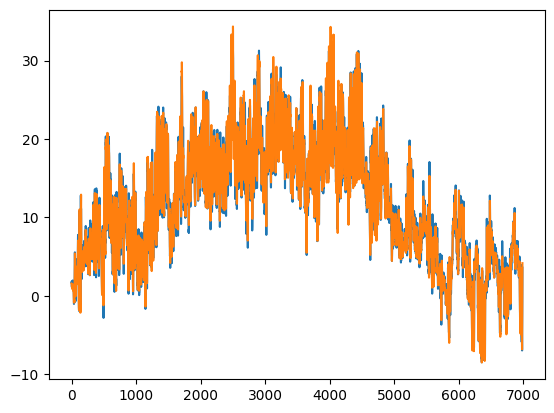

In [317]:
plt.plot(test_results['Test Predictions'][:,0])
plt.plot(test_results['Actuals'][:,0])

In [321]:
test_predictions.shape

(6986, 10)

In [325]:
test_res = test_results['Test Predictions']
act = test_results['Actuals']

In [327]:
for i in range(n_forecast):
    mae_day = np.mean(np.abs(act[:, i] - test_res[:, i]))
    print(f'MAE for Day {i+1}: {mae_day}')

MAE for Day 1: 0.7171946692644202
MAE for Day 2: 0.9252521911648686
MAE for Day 3: 1.2245053863784978
MAE for Day 4: 1.4992421537326186
MAE for Day 5: 1.7226673939932675
MAE for Day 6: 1.9120464282524883
MAE for Day 7: 2.0567768380193496
MAE for Day 8: 2.0906220199186074
MAE for Day 9: 2.1400930768135384
MAE for Day 10: 2.2993782577239834
